# Gradient prediction

This notebook will illustrate how to calculate gradients with respect to model input.

In [1]:
# First let's select and setup the model:
import kipoi
model_name = "Basset"
#kipoi.pipeline.install_model_requirements(model_name)
# get ahold of the model
model = kipoi.get_model(model_name)

For gradient prediction we need a set of parameters like:

 - `layer`: The gradient will then be calculated in repect to the activation of that layer
 - `filter_idx`: The filter from which the activation shall be used to calculate the gradient - this is optional and if not set then all filter outputs are passed to the avg_func
 - `avg_func`: How we want to average over multiple filter outputs - take the sum, the minimum, the maximum or the maximum of the absolute values.

The `Basset` model we are using here is a multitask model that predicts probabilities of accesible genomic regions in 164 cell types. It is a multi-task model and therefore accepts one input (600bp DNA sequence) and produces 164 predictions simulatneously. 

Let's start out with selecting model parameters. Most importantly we want to select a layer by its index. For PyTorch models the layers can be displayed just by running:

In [2]:
model.model

Sequential(
  (0): Conv2d(4, 300, kernel_size=(19, 1), stride=(1, 1))
  (1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(300, 200, kernel_size=(11, 1), stride=(1, 1))
  (5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(200, 200, kernel_size=(7, 1), stride=(1, 1))
  (9): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (12): Lambda()
  (13): Sequential(
    (0): Lambda()
    (1): Linear(in_features=2000, out_features=1000, bias=True)
  )
  (14): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()

Here we want to see which inputs were important for giving a prediction in the model output we will select the output from layer 21.1 - we don't want to calculate the gradients based on outputs of a nonlinearity.

The model is a multi-task model predicting chromatin accessibility for 164 cell types, we want to calculate the gradients with respect to exactly one of those cell types: K562. In order to select the filter which produces this value we can use the model task annotation that is stored in the Kipoi model:

In [3]:
filter_idx = model.schema.targets.column_labels.index('K562')
filter_idx

120

Now that we have decided about the model-related setup we need to produce model input data using the model dataloader. Just like for any other prediction with Kipoi we have to define the dataloader keyword arguments with which the dataloader can be executed. The `Basset` default dataloader takes two arguments: `fasta_file` and `intervals_file`. The `intervals_file` is a bed file defining regions for which input data is generated.

We want to look at a DNAse-seq peak in the K562 cell line. So we will first download a bed file of the peaks:

In [4]:
!wget -P example_data http://hgdownload.cse.ucsc.edu/goldenpath/hg19/encodeDCC/wgEncodeAwgDnaseUniform/wgEncodeAwgDnaseUwdukeK562UniPk.narrowPeak.gz

--2018-07-06 15:13:19--  http://hgdownload.cse.ucsc.edu/goldenpath/hg19/encodeDCC/wgEncodeAwgDnaseUniform/wgEncodeAwgDnaseUwdukeK562UniPk.narrowPeak.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1845863 (1.8M) [application/x-gzip]
Saving to: ‘example_data/wgEncodeAwgDnaseUwdukeK562UniPk.narrowPeak.gz.8’

100%[======================================>] 1,845,863    819KB/s   in 2.2s   

2018-07-06 15:13:22 (819 KB/s) - ‘example_data/wgEncodeAwgDnaseUwdukeK562UniPk.narrowPeak.gz.8’ saved [1845863/1845863]



Now let's randomly extract the first peak in the downloaded file in chromosome 22 into a bed file:

In [5]:
! gzip -dc example_data/wgEncodeAwgDnaseUwdukeK562UniPk.narrowPeak.gz | grep "^chr22" | head -n 1 > example_data/Basset_grad_query.bed
! cat example_data/Basset_grad_query.bed

grep: write error

gzip: stdout: Broken pipe
chr22	16197740	16197890	.	0	.	0	-1	-1	-1


There is one more thing we need to keep in mind - `Basset` only works with 600bp sequence length genomic regions, so we can centre our query region on the peak selected above:

In [6]:
model_seq_length = 600
with open("example_data/Basset_grad_query.bed", "r") as ifh:
    with open("example_data/Basset_grad_query_Basset.bed", "w") as ofh:
        for l in ifh:
            tokens = l.rstrip().split("\t")
            center = (int(tokens[1]) + int(tokens[2]))//2
            ofh.write("\t".join([tokens[0], str(center -model_seq_length//2),
                                 str(center + model_seq_length//2  + model_seq_length%2)]) + "\n")

In [7]:
! cat example_data/Basset_grad_query_Basset.bed

chr22	16197515	16198115


In [8]:
dataloader_arguments = {"fasta_file": "example_data/hg19_chr22.fa",
                        'intervals_file': "example_data/Basset_grad_query_Basset.bed"}

The `dataloader_arguments` are keyword arguments passed on to the dataloader in order to setup data generation. In the next step we run the `input_grad` pipeline to get gradients and model inputs.

In [9]:
grad_preds = model.pipeline.input_grad(dataloader_arguments, layer="21.1", filter_idx = filter_idx)

1it [00:00, 45.63it/s]


Now that the gradients are calculated we can plot the results using the `GradPlotter` class. Since we only have one batch of input data we don't have to worry about collating batches. The GradPlotter instantiation requires the input data, the gradient predictions and the name of the model. The model name is required as the model configuration is necessary to automatically identify whether a specific model input is a DNA-sequence input. As we will see here this has an impact on how data can be displayed:

In [10]:
# generate the GradPlotter instance:
from kipoi.postprocessing.gradient_vis import GradPlotter
gp = GradPlotter(grad_preds, model_name)

The Basset model only has DNA sequnce input. For DNA sequence input it is possible to display _grad*input_ as a seqlogo plot as can be seen above. You might have to execute the following cell twice since sometimes the first matplolib plot is not displayed in the notebook..

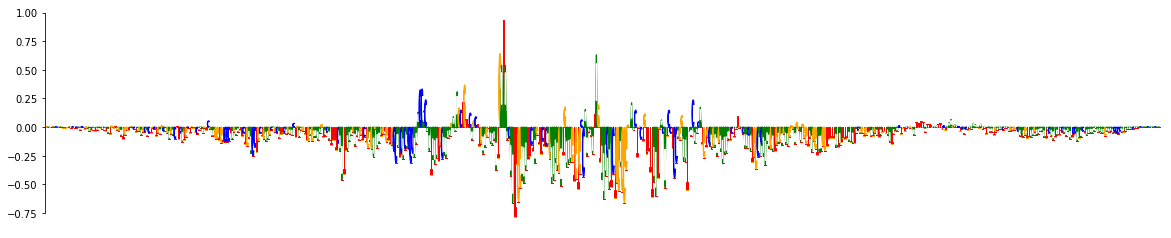

In [12]:
gp.plot(0)

Displaying 600bp in a seqlogo is not very useful, hence zooming is possible by genomic coordinates (`limit_region_genomic`) or by subsetting the _grad*input_ array directly using the `limit_region` parameter:

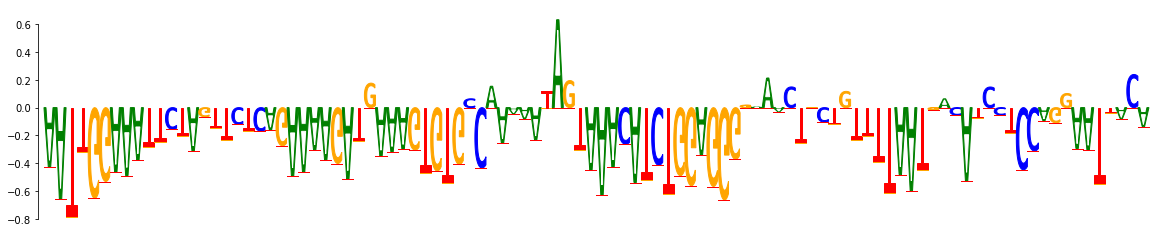

In [13]:
# subset model input sequence to bases 250 to 350 for plotting
gp.plot(0, limit_region=(250,350))

# CLI 
Using the equivalent command in the CLI the same plot can be produced.
Before we can do that we have to delete the file that we have just created a minute ago:

In [14]:
import os
os.unlink("example_data/Basset_grad_query_Basset_out.hdf5")

In [15]:
! kipoi postproc grad Basset --source kipoi --dataloader_args '{"fasta_file": \
   "example_data/hg19_chr22.fa", "intervals_file": "example_data/Basset_grad_query_Basset.bed"}'\
   --layer "21.1" --filter_idx 120 --output "example_data/Basset_grad_query_Basset_out.hdf5"

INFO [kipoi.remote] Update /nfs/research1/stegle/users/rkreuzhu/.kipoi/models/
Already up-to-date.
INFO [kipoi.remote] git-lfs pull -I Basset/**
INFO [kipoi.remote] model Basset loaded
INFO [kipoi.remote] git-lfs pull -I Basset/./**
INFO [kipoi.remote] dataloader Basset/. loaded
INFO [kipoi.data] successfully loaded the dataloader from /nfs/research1/stegle/users/rkreuzhu/.kipoi/models/Basset/dataloader.py::SeqDataset
INFO [kipoi.pipeline] dataloader.output_schema is compatible with model.schema
INFO [kipoi.cli.postproc] Using HDF5BatchWriter for file example_data/Basset_grad_query_Basset_out.hdf5
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 51.98it/s]
INFO [kipoi.cli.postproc] Done! Gradients stored in example_data/Basset_grad_query_Basset_out.hdf5


now we can visualise the plot identically in python:

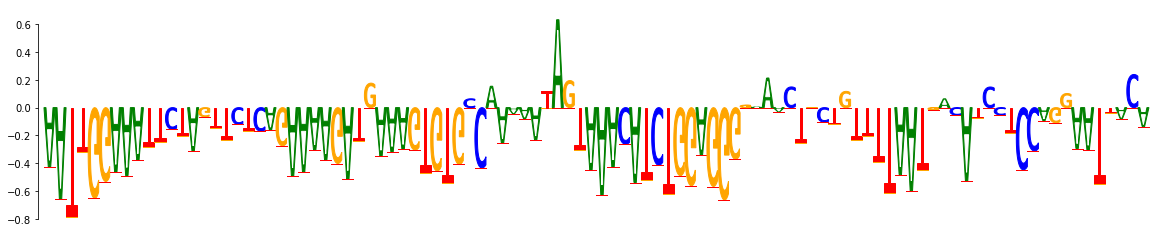

In [16]:
# generate the GradPlotter instance:
from kipoi.postprocessing.gradient_vis import GradPlotter
gp = GradPlotter.from_hdf5("example_data/Basset_grad_query_Basset_out.hdf5", "Basset")
gp.plot(0, limit_region=(250,350))

# Using FactorNet as an example

**_WARNING:_** You should restart the kernel at this point, because using a PyTorch model and loading a Keras model at the same time may cause the loading of the Keras model to hang!

FactorNet is a model to predict transcription factor binding that also uses open chromatin and mappability tracks as inputs. Here we will illustrate one of the strengths of using gradients to interpret model predictions.

Let's start with selecting a CTCF binding site and writing out the corresponding bed file:

In [1]:
with open("example_data/FactorNet_CTCF_grad_query.bed", "w") as ofh:
    chrom, center, intervals_len = "chr22", 28712021, 1002
    start = center - intervals_len//2
    end = center + intervals_len//2 + (intervals_len % 2)
    ofh.write("\t".join([chrom, str(start), str(end)]) + "\n")

Now let's load the model:

In [2]:
import kipoi
fn_model = kipoi.get_model('FactorNet/CTCF/meta_RNAseq_Unique35_DGF', source = "kipoi")

Using TensorFlow backend.
/nfs/research1/stegle/users/rkreuzhu/conda-envs/kipoi2/lib/python3.5/site-packages/keras/engine/topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [3]:
fn_datalaoder_arguments = fn_model.default_dataloader.example_kwargs
# prepend the model path for all path entries in the dataloader arguments.
fn_datalaoder_arguments = {k:fn_model.source_dir + "/" + v if not k == 'cell_line' else v 
                           for k,v in fn_datalaoder_arguments.items()}
fn_datalaoder_arguments['intervals_file'] = "example_data/FactorNet_CTCF_grad_query.bed"

# Check if the arguments have been set correctly:
fn_datalaoder_arguments

{'cell_line': 'PC-3',
 'dnase_file': '/nfs/research1/stegle/users/rkreuzhu/.kipoi/models/FactorNet/CTCF/meta_RNAseq_Unique35_DGF/example_files/dnase_synth.chr22.bw',
 'fasta_file': '/nfs/research1/stegle/users/rkreuzhu/.kipoi/models/FactorNet/CTCF/meta_RNAseq_Unique35_DGF/example_files/hg38_chr22.fa',
 'intervals_file': 'example_data/FactorNet_CTCF_grad_query.bed'}

Now run the gradient calculation pipeline on the `merge3` layer of the model. The model has only one output, so we select that one.

In [4]:
grad_preds = fn_model.pipeline.input_grad(fn_datalaoder_arguments, layer ='merge_3', filter_idx = [0])

1it [00:06,  6.85s/it]


At the moment we don't support more complex visualisation for model inputs that are not of the `special_type` `DNASequence`. Therefore and since FactorNet's `seq` input is a 1002x6 input, which is not a one-hot encoded DNA-sequence, so we will have to manually write a small function for plotting:

In [5]:
def plot_fnet(input_arr, grad_arr):
    import seaborn as sns
    import matplotlib.pylab as plt
    from kipoi.external.concise.seqplotting_deps import seqlogo
    plt.figure(figsize=(14,4))
    # calculate the grad*input values:
    values = (input_arr*grad_arr).T
    # get axes objects
    ax_s = plt.subplot(2,1,1)
    ax_h = plt.subplot(2,1,2)
    # make the plots
    seqlogo(values[:4,:].T, ax = ax_s)
    sns.heatmap(values[4:5,:], ax = ax_h, cbar=False)
    # plot formatting
    ax_s.get_xaxis().set_visible(False)
    sns.despine(trim = True, ax = ax_s, bottom = True)
    ax_h.get_xaxis().set_visible(False)
    ax_h.get_yaxis().set_visible(False)

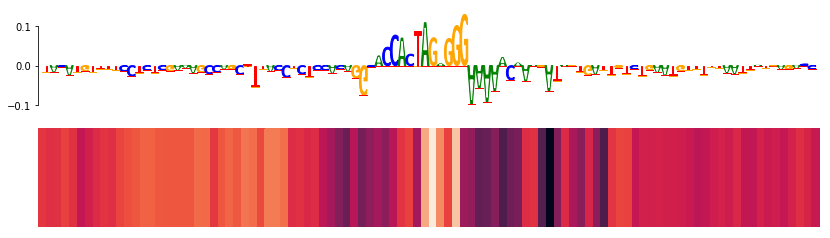

In [7]:
plot_fnet(grad_preds['inputs'][0][0,450:550,:], grad_preds['grads'][0][0,450:550,:])

FactorNet has a separate model input for the reverse-complement of the sequence, which is model input `1`. We can visualise it here:

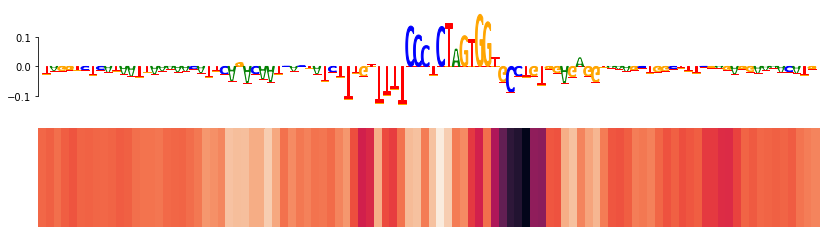

In [8]:
plot_fnet(grad_preds['inputs'][1][0,450:550,:], grad_preds['grads'][1][0,450:550,:])